<a href="https://colab.research.google.com/github/suelisena/dio-image-recommendations/blob/main/image_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
    import torch
    import torchvision
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    import faiss
    import os
    print("Todas as bibliotecas essenciais já estão instaladas.")
    print("Instalando bibliotecas necessárias (torch, torchvision, numpy, matplotlib, pillow, faiss-cpu)...")
    !pip install -q torch torchvision numpy matplotlib pillow faiss-cpu
    import torch
    import torchvision
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    import faiss
    import os
    print("Instalação concluída.")

# Importações adicionais para pré-processamento de imagens
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

Todas as bibliotecas essenciais já estão instaladas.
Instalando bibliotecas necessárias (torch, torchvision, numpy, matplotlib, pillow, faiss-cpu)...
Instalação concluída.



--- PASSO 1: Preparação dos Dados ---

--- PASSO 2: Construção do Modelo (Image Embedder) ---
Modelo Image Embedder criado, gerando embeddings de 512 dimensões.

--- PASSO 3: Definindo Similaridade ---
Para este exemplo, a similaridade será inferida do modelo pré-treinado e medida com Distância Euclidiana (L2).

--- PASSO 4: Lógica de Recomendação e Exibição de Imagens REAIS ---

--- Verificando o conteúdo da pasta: /content/imagens_catalogo ---
Arquivos encontrados em '/content/imagens_catalogo': ['bicicleta-2.jpg', '.ipynb_checkpoints', 'perfume-2.jpg', 'bicicleta-1.jpg', 'celular-1.jpg', 'perfume-1.jpg', 'sapato-2.jpg', 'celular-2.jpg', 'sapat0-1.jpg']

Gerando embeddings para os produtos...
  - Imagem para 'bicicleta-1' encontrada e embedding gerado: /content/imagens_catalogo/bicicleta-1.jpg
  - Imagem para 'bicicleta-2' encontrada e embedding gerado: /content/imagens_catalogo/bicicleta-2.jpg
  - AVISO: Imagem para o produto 'sapato-1' NÃO ENCONTRADA. Caminhos tentados:
      - /c

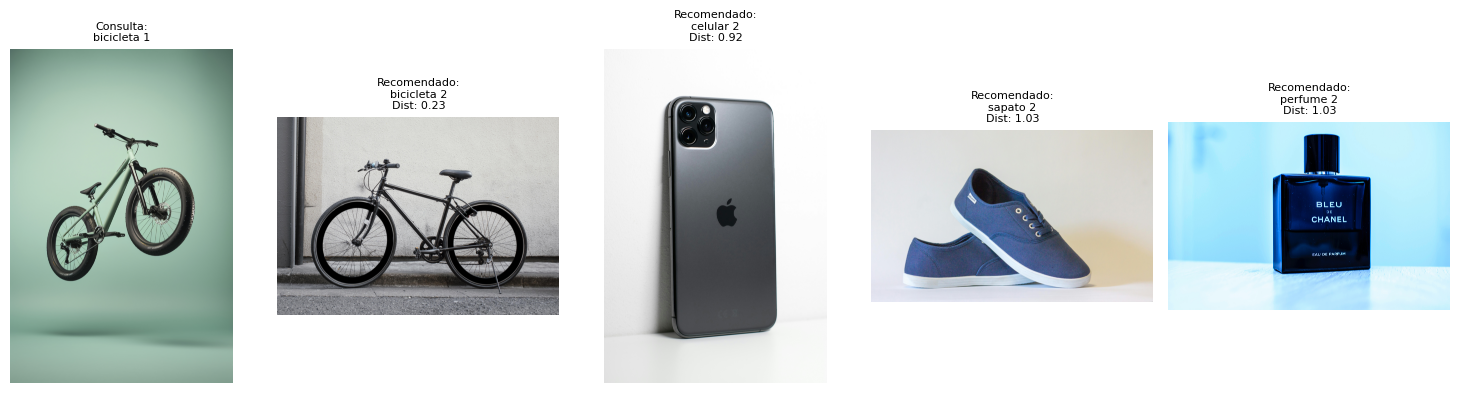

In [5]:


# --- Configurações de Caminho ---
PASTA_IMAGENS_PRODUTOS = "/content/imagens_catalogo"

# --- Passo 1: Preparação dos Dados ---
print("\n--- PASSO 1: Preparação dos Dados ---")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Passo 2: Construção do Modelo (Image Embedder) ---
print("\n--- PASSO 2: Construção do Modelo (Image Embedder) ---")

base_model = torchvision.models.resnet18(pretrained=True)
embedding_dim = base_model.fc.in_features # 512 para ResNet-18
base_model.fc = nn.Identity()

class ImageEmbedder(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        return F.normalize(self.base_model(x), p=2, dim=1)

model = ImageEmbedder(base_model)
model.eval()

print(f"Modelo Image Embedder criado, gerando embeddings de {embedding_dim} dimensões.")

# --- Passo 3: Definindo Similaridade ---
print("\n--- PASSO 3: Definindo Similaridade ---")
print("Para este exemplo, a similaridade será inferida do modelo pré-treinado e medida com Distância Euclidiana (L2).")


# --- Passo 4: Lógica de Recomendação e Exibição de Imagens REAIS ---
print("\n--- PASSO 4: Lógica de Recomendação e Exibição de Imagens REAIS ---")

# --- ATENÇÃO: LISTA DE PRODUTOS AJUSTADA PARA SEUS NOMES DE ARQUIVO ---
# Seus IDs de produto agora correspondem aos prefixos dos nomes dos arquivos.
PRODUTOS_EXEMPLO = [
    "bicicleta-1", "bicicleta-2", # Adicione mais bicicletas se tiver
    "sapato-1", "sapato-2",      # Adicione mais sapatos se tiver
    "celular-1", "celular-2",    # Adicione mais celulares se tiver
    "perfume-1", "perfume-2",    # Adicione mais perfumes se tiver
    # Exemplo: Adicione outros produtos que você tenha na pasta:
    # "bicicleta-3", "sapato-3", "celular-3", "perfume-3"
]

# --- VERIFICAÇÃO DE IMAGENS NO DIRETÓRIO ---
print(f"\n--- Verificando o conteúdo da pasta: {PASTA_IMAGENS_PRODUTOS} ---")
if not os.path.exists(PASTA_IMAGENS_PRODUTOS):
    print(f"ERRO CRÍTICO: A pasta '{PASTA_IMAGENS_PRODUTOS}' NÃO EXISTE!")
    print("Certifique-se de que você carregou suas imagens para o local correto no Colab ou que o caminho está certo.")
    exit()

arquivos_na_pasta = os.listdir(PASTA_IMAGENS_PRODUTOS)
print(f"Arquivos encontrados em '{PASTA_IMAGENS_PRODUTOS}': {arquivos_na_pasta}")
if not arquivos_na_pasta:
    print("AVISO: A pasta está vazia! Nenhuma imagem será carregada.")

# --- 4.1. Gerar Embeddings para o seu Catálogo de Produtos ---
embeddings_catalogo = []
ids_catalogo_validos = [] # Armazena os IDs dos produtos para os quais encontramos imagens e embeddings

print(f"\nGerando embeddings para os produtos...")

for product_id in PRODUTOS_EXEMPLO:
    image_path = None
    # Tenta diferentes extensões de imagem
    for ext in ['.jpg', '.png', '.jpeg', '.webp', '.gif']:
        temp_path = os.path.join(PASTA_IMAGENS_PRODUTOS, f"{product_id}{ext}")
        if os.path.exists(temp_path):
            image_path = temp_path
            break

    if image_path:
        try:
            img = Image.open(image_path).convert("RGB")
            img_tensor = preprocess(img).unsqueeze(0)

            with torch.no_grad():
                embedding = model(img_tensor).squeeze(0)

            embeddings_catalogo.append(embedding.numpy())
            ids_catalogo_validos.append(product_id)
            print(f"  - Imagem para '{product_id}' encontrada e embedding gerado: {image_path}")
        except Exception as e:
            print(f"  - ERRO ao processar imagem '{product_id}' ({image_path}): {e}")
            print("    Verifique se o arquivo não está corrompido ou se é uma imagem válida.")
    else:
        print(f"  - AVISO: Imagem para o produto '{product_id}' NÃO ENCONTRADA. Caminhos tentados:")
        for ext in ['.jpg', '.png', '.jpeg', '.webp', '.gif']:
            print(f"      - {os.path.join(PASTA_IMAGENS_PRODUTOS, f'{product_id}{ext}')}")

if not embeddings_catalogo:
    print("ERRO FINAL: Nenhuma imagem foi carregada ou processada com sucesso. Não é possível continuar.")
    exit()

embeddings_catalogo_np = np.vstack(embeddings_catalogo)
print(f"\nTotal de {len(ids_catalogo_validos)} embeddings gerados e adicionados ao catálogo.")

# --- 4.2. Preparar um índice para busca eficiente com FAISS ---
indice_faiss = faiss.IndexFlatL2(embedding_dim)
indice_faiss.add(embeddings_catalogo_np)
print(f"Índice FAISS criado e {indice_faiss.ntotal} embeddings adicionados.")


# --- 4.3. Realizar uma Consulta e Exibir Recomendações ---

# ATENÇÃO: id_produto_consulta DEVE ser um dos IDs que você listou em PRODUTOS_EXEMPLO
id_produto_consulta = "bicicleta-1" # <-- Mude este ID para testar outras consultas!

if id_produto_consulta not in ids_catalogo_validos:
    print(f"\nERRO: O produto de consulta '{id_produto_consulta}' não foi encontrado ou processado no catálogo de imagens válidas.")
    print("Por favor, verifique se a imagem existe na pasta, se o nome está correto e se foi processada sem erros.")
else:
    query_index = ids_catalogo_validos.index(id_produto_consulta)
    embedding_consulta_np = embeddings_catalogo_np[query_index].reshape(1, -1)

    num_recomendacoes = 4
    distancias, indices = indice_faiss.search(embedding_consulta_np, num_recomendacoes + 1)

    print(f"\n--- Recomendações Visuais para: {id_produto_consulta.replace('-', ' ')} ---") # Ajuste na exibição do título

    plt.figure(figsize=(num_recomendacoes * 3 + 3, 4))

    # --- Exibe a imagem de consulta ---
    ax = plt.subplot(1, num_recomendacoes + 1, 1)
    query_image_path = None
    for ext in ['.jpg', '.png', '.jpeg', '.webp', '.gif']:
        temp_path = os.path.join(PASTA_IMAGENS_PRODUTOS, f"{id_produto_consulta}{ext}")
        if os.path.exists(temp_path):
            query_image_path = temp_path
            break

    if query_image_path:
        try:
            img_query = Image.open(query_image_path)
            plt.imshow(img_query)
            plt.title(f"Consulta:\n{id_produto_consulta.replace('-', ' ')}", fontsize=8) # Ajuste na exibição do título
            plt.axis('off')
        except Exception as e:
            plt.text(0.5, 0.5, f"ERRO AO CARREGAR\nIMAGEM DE CONSULTA\n({e})", ha='center', va='center', fontsize=8, color='red')
            plt.title(f"Consulta:\n{id_produto_consulta.replace('-', ' ')}\n(Erro)", fontsize=8) # Ajuste na exibição do título
            plt.axis('off')
    else:
        plt.text(0.5, 0.5, "IMAGEM DE CONSULTA\nNÃO ENCONTRADA", ha='center', va='center', fontsize=10, color='red')
        plt.title(f"Consulta:\n{id_produto_consulta.replace('-', ' ')}\n(Ausente)", fontsize=8) # Ajuste na exibição do título
        plt.axis('off')

    # --- Exibe as imagens recomendadas ---
    reco_plot_idx = 1
    for i in range(num_recomendacoes + 1):
        current_product_id = ids_catalogo_validos[indices[0][i]]
        current_distance = distancias[0][i]

        if current_product_id == id_produto_consulta and current_distance < 0.0001:
            continue

        reco_plot_idx += 1
        if reco_plot_idx > num_recomendacoes + 1:
            break

        ax = plt.subplot(1, num_recomendacoes + 1, reco_plot_idx)

        recommended_image_path = None
        for ext in ['.jpg', '.png', '.jpeg', '.webp', '.gif']:
            temp_path = os.path.join(PASTA_IMAGENS_PRODUTOS, f"{current_product_id}{ext}")
            if os.path.exists(temp_path):
                recommended_image_path = temp_path
                break

        if recommended_image_path:
            try:
                img_recommended = Image.open(recommended_image_path)
                plt.imshow(img_recommended)
                plt.title(f"Recomendado:\n{current_product_id.replace('-', ' ')}\nDist: {current_distance:.2f}", fontsize=8) # Ajuste na exibição do título
                plt.axis('off')
            except Exception as e:
                plt.text(0.5, 0.5, f"ERRO AO CARREGAR\nIMAGEM\n({e})", ha='center', va='center', fontsize=8, color='gray')
                plt.title(f"Recomendado:\n{current_product_id.replace('-', ' ')}\n(Erro)", fontsize=8) # Ajuste na exibição do título
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, "IMAGEM\nNÃO ENCONTRADA", ha='center', va='center', fontsize=10, color='gray')
            plt.title(f"Recomendado:\n{current_product_id.replace('-', ' ')}\n(Ausente)", fontsize=8) # Ajuste na exibição do título
            plt.axis('off')

    plt.tight_layout()
    plt.show()